# Study Sky Background in Monocam Images
==================================================================

- Creation : Wedndesday 2016 June 15th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Raw Spectrum of HD159222


## 1) Import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [4]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-15 16:43:15.905674
fits date format for the analysis :  2016-06-15T16:43:15


## 2) Configuration of the detector

In [5]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

## 3) Configuration of the input file

- HD158485_grat_science.fits
- HD159222_grat_science.fits
- HD163466_grat_science.fits


In [6]:
#object_name='HD158485_grat'
object_name='HD159222_grat'
#object_name='HD163466_grat'

In [7]:
path='.'
basefilename=object_name +'_science.fits' # check
filename=os.path.join(path,basefilename)
outputfigfilename='SkyBackground_notcal_'+object_name+'_hist.pdf'
outputfigfilename2='SkyBackground_cal_'+object_name+'_hist.pdf'
inputfitsfilename=object_name+'.fits'


## 4) Read the images

In [8]:
allimages = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allimages.append(ccd_chan)

## 5) Shows the Histograms

In [9]:
def ShowHistoSetFixedBound(ccdlist,maintitle,datafile,figfile,Vmin=0.5,Vmax=1.5):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
   
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    
    #mn,mx,mm,mr=MinMaxMeanStd(ccdlist)
    #V_MIN=mm-nbsig*mr
    #V_MAX=mm+nbsig*mr
    V_MIN=Vmin
    V_MAX=Vmax
    
    BINWIDTH=(Vmax-Vmin)/500.
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)
    all_histos= []
    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = ccdlist[index].data[0:2000,:]
        data=image_data.flatten()
        themedian=np.median(data)
        thelabel=" median = {:1.2f} ADU".format(themedian)
        hist=axarr[iy,ix].hist(data,bins=np.arange(Vmin, Vmax + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True,label=thelabel)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        all_histos.append(hist)
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(V_MIN,V_MAX)
        axarr[iy,ix].set_ylim(1.,1e7)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].legend(loc='best')
        #axarr[iy,ix].set_xscale('log')

    plt.yscale('log')

    title=maintitle+ ' from file {}'.format(datafile)
    plt.suptitle(title,size=16)
    plt.savefig(figfile, bbox_inches='tight')
    return all_histos

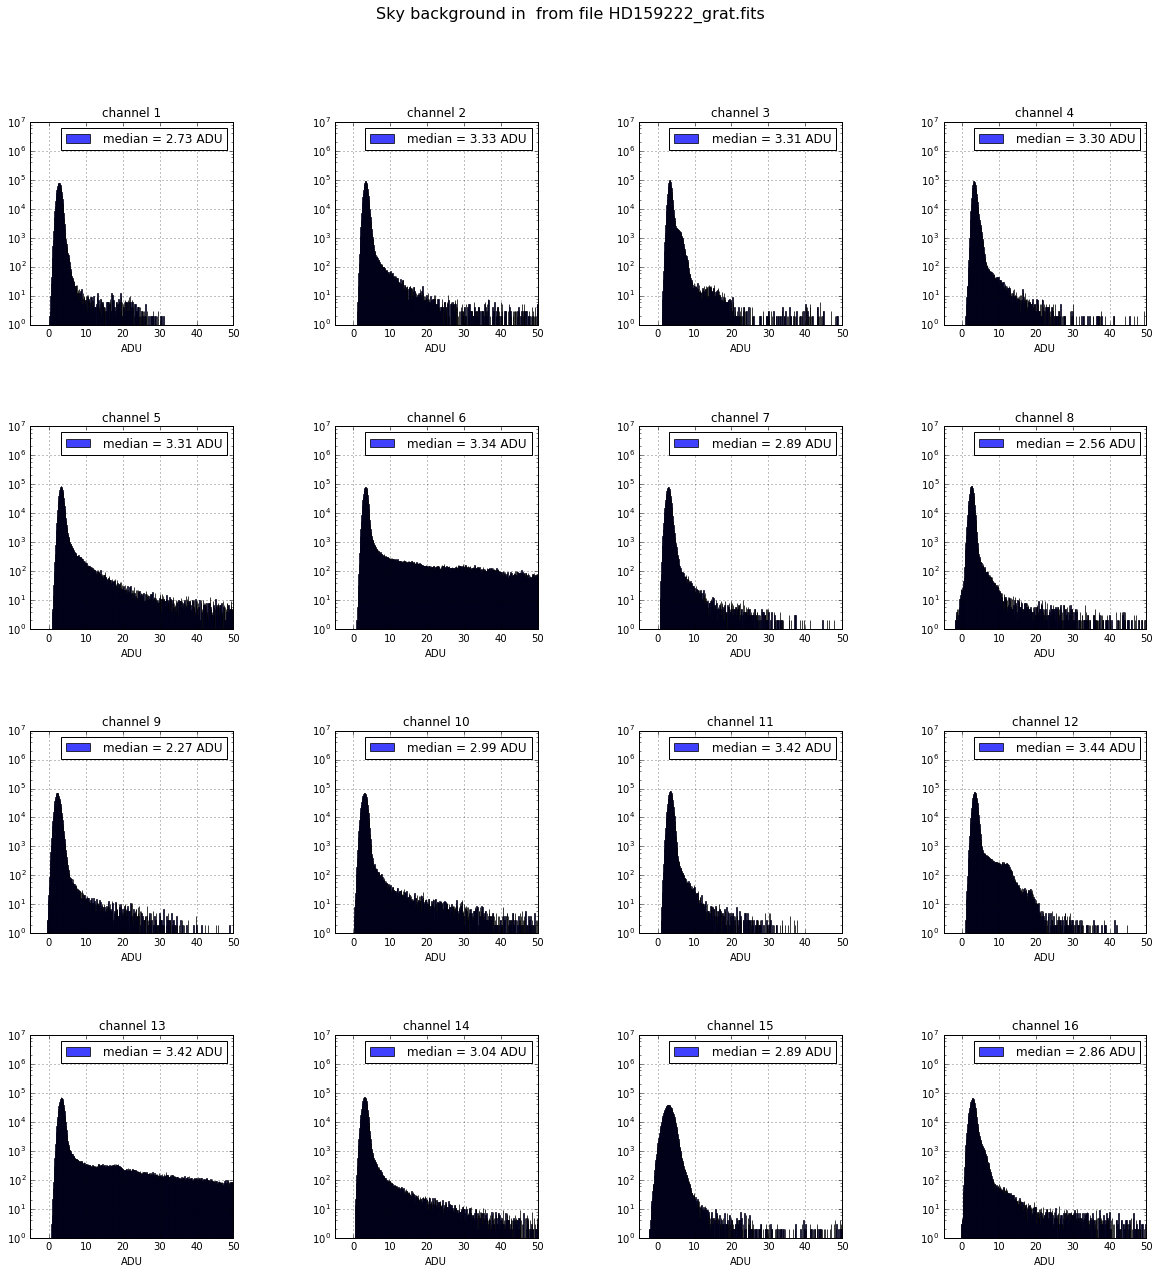

In [10]:
all_histo_notcal=ShowHistoSetFixedBound(allimages,'Sky background in ',inputfitsfilename,outputfigfilename,Vmin=-5,Vmax=50.)

In [11]:
themedian_notcal=np.zeros(NB_OF_CHAN_AMPL)
themax_notcal=np.zeros(NB_OF_CHAN_AMPL)
for chan in range(NB_OF_CHAN_AMPL):
    ind=np.where(all_histo_notcal[chan][0]==np.max(all_histo_notcal[chan][0]))[0][0]
    themax_notcal[chan]=all_histo_notcal[chan][1][ind]
    themedian_notcal[chan]=np.median(allimages[chan].data.flatten())

print 'uncalibrated sky background accuracy (med,max) = ' , themedian_notcal.std()/themedian_notcal.mean(), themax_notcal.std()/themax_notcal.mean()


uncalibrated sky background accuracy (med,max) =  0.109440833255 0.110644603695


## Calibrate with the ADC gain

In [12]:
# ADU to e-
gain =np.array( [3.707220,3.724264,3.758828,3.794040,3.724264,3.776352,3.758828,3.776352, 3.724264,
                 3.657009,3.640573,3.624284,3.640573,3.707220,3.673594,3.640573])

In [13]:
gain_norm=gain/np.mean(gain)

In [14]:
# in e-
noise =np.array([7.105902,6.860052,7.387405,7.222204,7.250763,7.315250,7.104838,7.272336,8.485139,
                 8.022778,8.157399,8.021112,8.015486,7.928829,16.031720,7.938155])

In [15]:
allimages_calibrated = []
for chan in range(NB_OF_CHAN_AMPL):
    ccd_chan=ccdproc.gain_correct(allimages[chan],gain=gain_norm[chan])
    allimages_calibrated.append(ccd_chan)

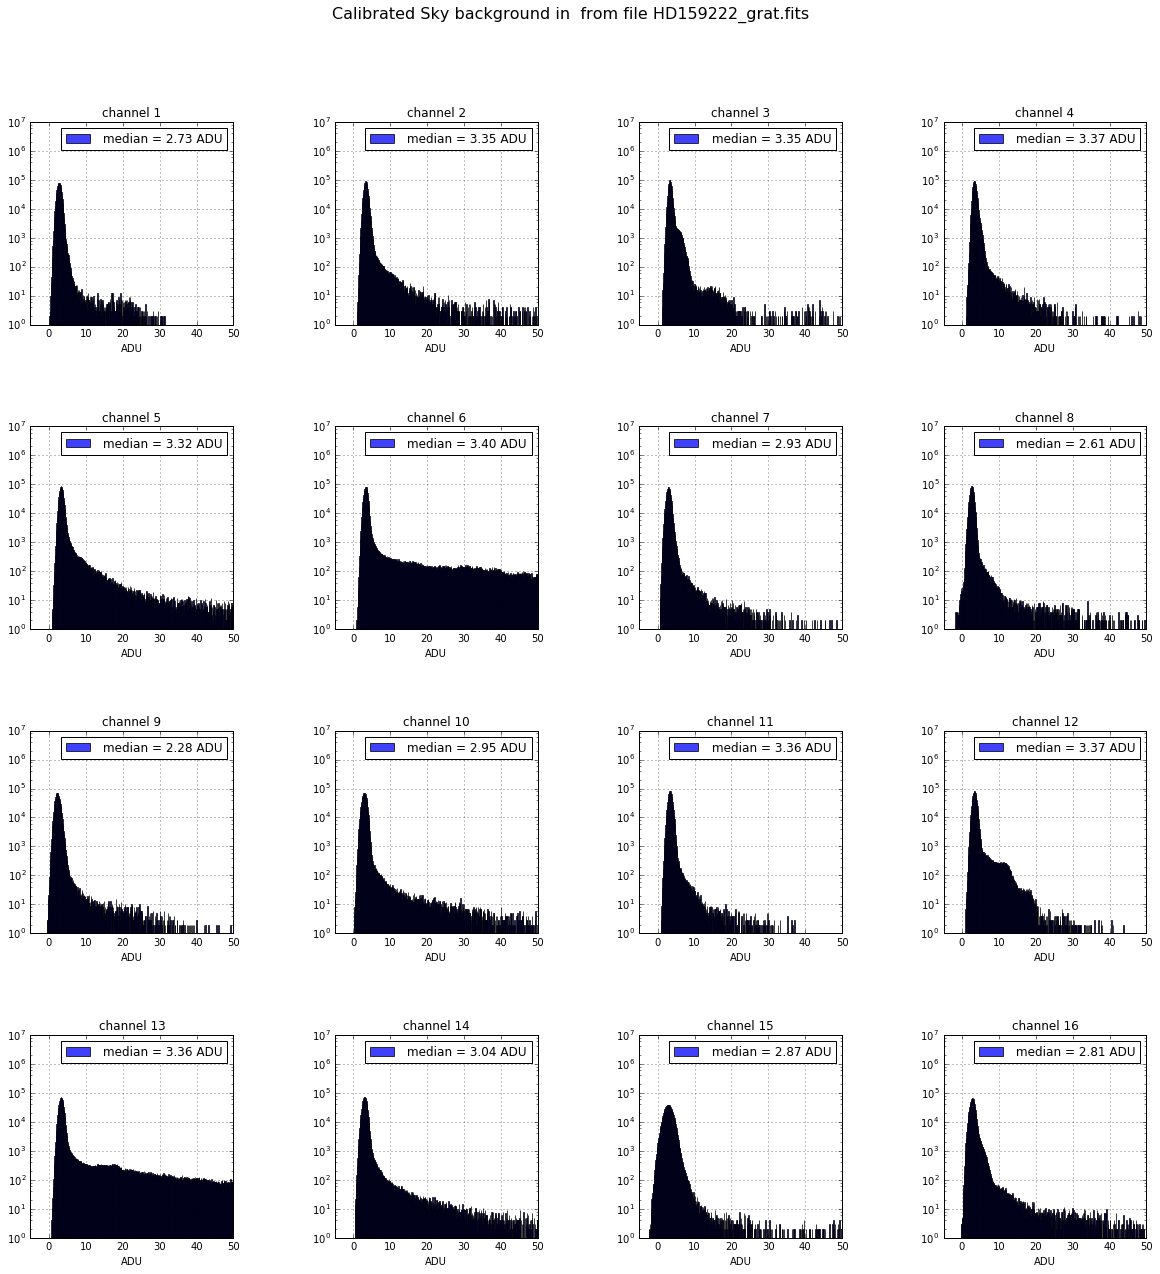

In [16]:
all_histos_cal=ShowHistoSetFixedBound(allimages_calibrated,'Calibrated Sky background in ',inputfitsfilename,outputfigfilename2,Vmin=-5,Vmax=50.)

In [17]:
themedian_cal=np.zeros(NB_OF_CHAN_AMPL)
themax_cal=np.zeros(NB_OF_CHAN_AMPL)
for chan in range(NB_OF_CHAN_AMPL):
    ind=np.where(all_histos_cal[chan][0]==np.max(all_histos_cal[chan][0]))[0][0]
    themax_cal[chan]=all_histos_cal[chan][1][ind]
    themedian_cal[chan]=np.median(allimages_calibrated[chan].data.flatten())

print 'calibrated sky background accuracy = ' , themedian_cal.std()/themedian_cal.mean(), themax_cal.std()/themax_cal.mean()

calibrated sky background accuracy =  0.108015054811 0.107525853683
